In [1]:
import sys
sys.path.append("..")

from glob import glob
import matplotlib.pyplot as plt
import ipywidgets as ipw
from IPython.display import Audio
import numpy as np
import pandas as pd
import pickle
import yaml

from lib import utils
from lib.notebooks import plot_groups_metrics
from communicative_agent import CommunicativeAgent

In [2]:
NB_TRAINING = 5
JERK_LOSS_WEIGHTS = [0, 0.15]

In [7]:
metrics_name = ["inverse_model_jerk", "inverse_model_repetition_error"]
groups_metrics = { metric_name: {} for metric_name in metrics_name }

final_configs = utils.read_yaml_file("communicative_final_configs.yaml")
final_quantizer_configs = utils.read_yaml_file("../quantizer/quantizer_final_configs.yaml")

for config_name, config in final_configs.items():
    quantizer_name = config_name.split("-")[0]
    quantizer_config = final_quantizer_configs["%s-cepstrum" % quantizer_name]
    if not config_name.startswith("pb2007"): continue

    for i_training in range(NB_TRAINING):
        quantizer_config["dataset"]["datasplit_seed"] = i_training
        quantizer_signature = utils.get_variable_signature(quantizer_config)

        for jerk_loss_weight in JERK_LOSS_WEIGHTS:
            config["sound_quantizer"]["name"] = "%s-%s" % (quantizer_signature, i_training)
            config["training"]["jerk_loss_weight"] = jerk_loss_weight

            agent_group = "%s jerk=%s" % (config_name, jerk_loss_weight)
            
            agent_signature = utils.get_variable_signature(config)
            agent_name = "%s-%s" % (agent_signature, i_training)
            print(jerk_loss_weight)
            print(agent_name)
            agent_path = "../out/communicative_agent/%s" % agent_name
            with open("%s/metrics.pickle" % agent_path, "rb") as f:
                metrics = pickle.load(f)
            
            final_loss_index = np.argmin(metrics["validation"]["inverse_model_repetition_error"])
            
            for metric_name in metrics_name:
                if agent_group not in groups_metrics[metric_name]:
                    groups_metrics[metric_name][agent_group] = []
                agent_metric = metrics["test"][metric_name][final_loss_index]
                groups_metrics[metric_name][agent_group].append(agent_metric)

0
bd7b01b16ea86da2e4fb0f082cd46687-0
0.15
5e5dce5ba23ccc653b8cb0cbd29c7cc9-0
0
2d2c8282327ffc71177907b6649a441e-1
0.15
ab6a5478e5bc27aca498e1b80439f22b-1
0
97a400f946a1202ec39bbf5546749656-2
0.15
255f581101c5169ce56d919198f62c33-2
0
bc1e67df2dec1d7577fddf6a3bd48bae-3
0.15
aabf90478c0629fd266913e4b0ea1b72-3
0
79dc16c932448a9a1418d56a3b263c4f-4
0.15
8b2ea1d806d35213698be3161ab02bbb-4
0
6c31ae73341624b9c8dcc87fe0785d2a-0
0.15
f103235e599e91d1d8f16726de633c41-0
0
f9ce1417898b61bca0230bc5c43db9b8-1
0.15
4ea8e7d887c3aa4692d5c1a162087f11-1
0
5712219048d80e333c923cb044ec1e95-2
0.15
4936c9a76095bd94ddd8ce4f066b8bde-2
0
f4ac107bd283e0c40ea2ee25d1020363-3
0.15
8969824d55dc82ed4a29661da4ffdb1d-3
0
25c7a23c9dbdb22b04d89cd29539d42b-4
0.15
5b6a02d2fc806a8d8f6c93b3d0fb6202-4


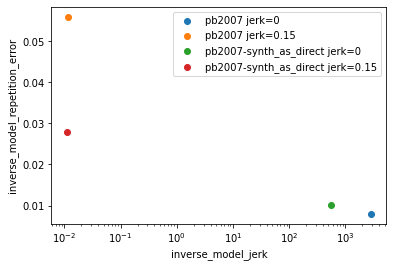

In [8]:
plot_metrics = ["inverse_model_jerk", "inverse_model_repetition_error"]
plot_scales = ["log", "linear"]

plt.figure()
ax = plt.subplot()
ax.set_xlabel(plot_metrics[0])
ax.set_ylabel(plot_metrics[1])
ax.set_xscale(plot_scales[0])
ax.set_yscale(plot_scales[1])

groups_name = groups_metrics[plot_metrics[0]].keys()
for group_name in groups_name:
    x = np.mean(groups_metrics[plot_metrics[0]][group_name])
    y = np.mean(groups_metrics[plot_metrics[1]][group_name])
    ax.scatter(x, y, label=group_name)
ax.legend()
plt.show()

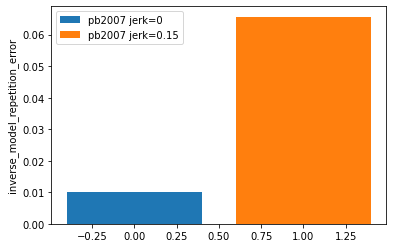

In [13]:
plot_metrics = ["inverse_model_jerk", "inverse_model_repetition_error"]

plt.figure()
ax = plt.subplot()
ax.set_ylabel(plot_metrics[1])

groups_name = groups_metrics[plot_metrics[0]].keys()
for i_group, group_name in enumerate(groups_name):
    if not group_name.startswith("pb2007 "): continue
    ax.bar(i_group, groups_metrics[plot_metrics[1]][group_name], label=group_name)
ax.legend()
plt.show()